In [1]:
%matplotlib inline
import re
from pathlib import Path

import numpy as np

from spectrometer import FID1D, plot, process
cm = 1 / 2.54
figsize = (13.0*cm, 6.5*cm)  # Thesis: 16cm * 8cm

Did not find any configuration file. Using defaults.


In [2]:
# Load raw *.fid data
fids: list[FID1D] = []
for file in Path("../data/20230822-105316-Water-1H-rabi-nutation").glob("*.fid"):
    fids.append(FID1D.from_file(file))

# Extract pulse lengths from metadata
pattern = r"length=(.*)us,delay="
pulse_lengths_us = [float(re.search(pattern, str(fid.pulse))[1]) for fid in fids]

# Sort data by pulse lengths
pulse_lengths_us, fids = zip(*sorted(zip(pulse_lengths_us, fids)))

Pulse length of 90-degree pulse candidate: 6.654060066740823
Pulse number: 17


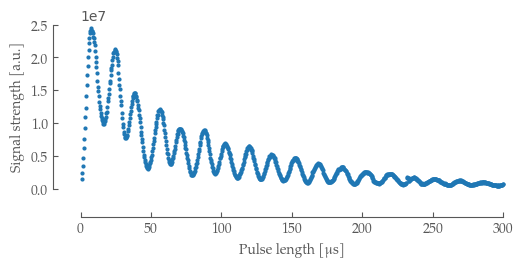

In [3]:
# Find FID with largest signal strength and estimate phase shift on it
signal_strengths = []
for _i, fid in enumerate(fids):
    spec, p0 = fid.spectrum(phase_shift_kwargs=False)  # No phase shift
    x = np.flip(spec.hz.scale)
    y = np.flip(spec[:])
    y = np.square(np.abs(y))
    integral = np.trapz(y)
    signal_strengths.append(integral)

# Find FID with largest signal, use median to avoid outliers
max_pulse_idx = int(np.argmax(signal_strengths))
median_max_pulse_idx = np.where(
    signal_strengths
    == np.percentile(
        signal_strengths[max_pulse_idx - 5 : max_pulse_idx + 5],
        50,
        method="closest_observation",
    )
)[0][
    0
]  # 'median' picking closest on even array
print(
    f"Pulse length of 90-degree pulse candidate: {pulse_lengths_us[median_max_pulse_idx]}"
)
print(f"Pulse number: {median_max_pulse_idx}")

# Plot raw data
# TODO: Why this shape?
# => composite pulses? very inhomogenous, sinc excites less at edges of peak?
fig, axes = plot.subplots(
    figsize=figsize,  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    pulse_lengths_us,
    np.real(signal_strengths),
    linestyle="",
    marker="o",
    markersize=2,
)
axes.set_ylabel("Signal strength [a.u.]")
axes.set_xlabel("Pulse length [μs]")

plot.format_axes(axes)

Estimated phase offset: 14.64325000000002
Estimated Full Width at Half Maximum: 150.50464205913485 Hz
Estimated peak location: -579.1879748314328
4113
8


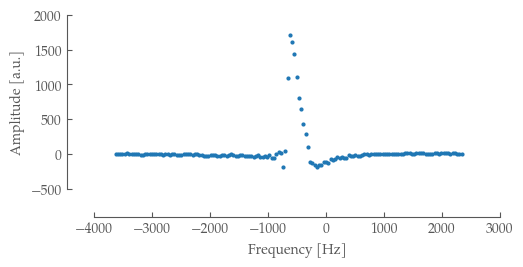

In [4]:
# Estimate zero-order phase correction
spec, p0 = fids[median_max_pulse_idx].spectrum()
print(f"Estimated phase offset: {p0}")

# Estimate peak width to integrate over
fit_lorentz = spec.hz.fit_lorentz()
print(f"Estimated Full Width at Half Maximum: {fit_lorentz.fwhm} Hz")
print(f"Estimated peak location: {fit_lorentz.position}")

spec.hz.crop_around(spec.hz.max_peak, 6000).plot(figsize=figsize)

fit_lorentz_idx = spec.fit_lorentz()
peak_idx = spec.max_peak  # int(np.round(fit_lorentz_idx.position))
peak_width_idx = int(np.round(fit_lorentz_idx.fwhm * 2))
print(peak_idx)
print(peak_width_idx)

In [5]:
# Process rabi nutation
signal_strengths = []
for fid in fids:
    spec, p0 = fid.spectrum(
        phase_shift_kwargs={"p0": p0}
    )  # All with same phase correction
    integral = spec.hz.integrate_around(fit_lorentz.position, fit_lorentz.fwhm * 4)
    signal_strengths.append(integral)

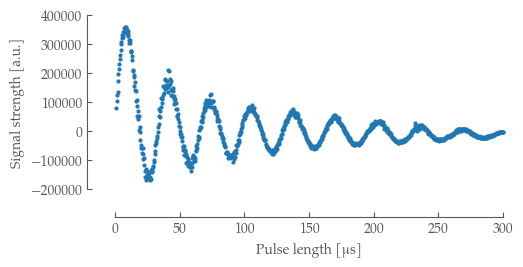

In [6]:
# Plot raw data
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=figsize,  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    pulse_lengths_us,
    np.real(signal_strengths),
    linestyle="",
    marker="o",
    markersize=2,
)
axes.set_ylabel("Signal strength [a.u.]")
axes.set_xlabel("Pulse length [μs]")

plot.format_axes(axes)

fig.savefig("rabi_nutation_raw.pdf")

Amplitude: 331423.9205384516
Frequency: 0.03097051250293314 MHz
Period/2pi-pulse: 32.288777911095025 us
Offset: 4056.589990672214
Phase: -0.20413639791256818
Lambda: 0.014213444841096667 MHz
'T2*': 70.35592083268978 us
pi/2-pulse: 8.072194477773756 us


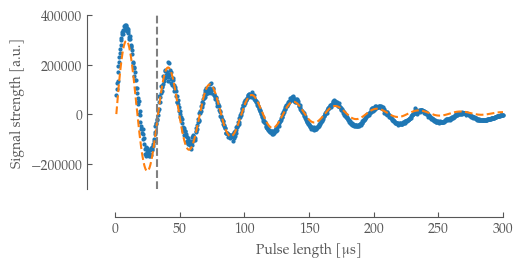

In [7]:
# Try to plot simple least squares fit
fit = process.decaying_sinus.fit(pulse_lengths_us, np.real(signal_strengths))
pulse_lengths_us_fine = np.linspace(
    pulse_lengths_us[0], pulse_lengths_us[-1], len(pulse_lengths_us) * 10
)
print(f"Amplitude: {fit.amplitude}")
print(f"Frequency: {fit.freq} MHz")
print(f"Period/2pi-pulse: {fit.period} us")
print(f"Offset: {fit.offset}")
print(f"Phase: {fit.phase}")
print(f"Lambda: {fit.lambda_} MHz")
print(f"'T2*': {1/fit.lambda_} us")
print(f"pi/2-pulse: {fit.period / 4} us")

# Plot raw data
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=figsize,  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    pulse_lengths_us,
    np.real(signal_strengths),
    linestyle="",
    marker="o",
    markersize=2,
)
axes.set_ylabel("Signal strength [a.u.]")
axes.set_xlabel("Pulse length [μs]")

plot.format_axes(axes)
axes.plot(
    pulse_lengths_us_fine,
    fit(pulse_lengths_us_fine),
    linestyle="--",
)

axes.vlines([fit.period], *axes.get_ylim(), linestyles="dashed", colors="grey")

# Save plot
fig.savefig(
    "rabi_nutation_fit.pdf",
)